In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
import os
from skimage.color import rgb2gray

In [22]:
def extract_glcm_features(image_path):
    # Load and convert image to grayscale
    image = imread(image_path)
    gray_image = rgb2gray(image)
    gray_image = (gray_image * 255).astype(np.uint8)  # Quantize to 8-bit
    
    # Compute GLCM for different distances and angles
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    
    # Extract GLCM features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    return [contrast, homogeneity, energy, correlation]

# Example usage: Extract GLCM features for all images in a directory
def process_images(image_dir):
    glcm_features = []
    for label in ['english_willow', 'kashmir_willow', 'other']:
        class_dir = os.path.join(image_dir, label)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            glcm_features.append(extract_glcm_features(img_path))
    return np.array(glcm_features)

# Get GLCM features for training, validation, and test sets
train_glcm_features = process_images('dataset/train')
val_glcm_features = process_images('dataset/valid')
test_glcm_features = process_images('dataset/test')

# Save GLCM features for train, validation, and test sets
os.makedirs('glcm_features', exist_ok=True)
np.save('glcm_features/train_glcm_features.npy', train_glcm_features)
np.save('glcm_features/val_glcm_features.npy', val_glcm_features)
np.save('glcm_features/test_glcm_features.npy', test_glcm_features)


In [23]:
# Load InceptionV3 model with pre-trained weights, excluding the top layer
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the InceptionV3 layers to retain pre-trained weights
for layer in inception_base.layers:
    layer.trainable = False

# Path for CNN features from InceptionV3
cnn_features = inception_base.output
cnn_features = GlobalAveragePooling2D()(cnn_features)

# Input for GLCM features (4 features from GLCM)
glcm_input = Input(shape=(4,), name='glcm_features')

# Combine CNN features with GLCM features
combined_features = Concatenate()([cnn_features, glcm_input])

# Fully connected layer for final classification
x = Dense(1024, activation='relu')(combined_features)
predictions = Dense(3, activation='softmax')(x)  # Binary classification

# Create the model
model = Model(inputs=[inception_base.input, glcm_input], outputs=predictions)


In [24]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
# ImageDataGenerator for the images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load the image data
train_image_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_image_generator = val_datagen.flow_from_directory(
    'dataset/valid',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1058 images belonging to 3 classes.
Found 213 images belonging to 3 classes.


In [26]:
def combined_generator(image_gen, glcm_features):
    while True:
        batch_image, batch_labels = next(image_gen)
        batch_size = batch_image.shape[0]
        # Get the corresponding GLCM features
        batch_glcm = glcm_features[:batch_size]
        yield [batch_image, batch_glcm], batch_labels


In [27]:
import pandas as pd

# Load saved GLCM features when you need to use them again
train_glcm_features = np.load('glcm_features/train_glcm_features.npy')
val_glcm_features = np.load('glcm_features/val_glcm_features.npy')
test_glcm_features = np.load('glcm_features/test_glcm_features.npy')

In [28]:
# Train the combined model
history = model.fit(
    combined_generator(train_image_generator, train_glcm_features),
    steps_per_epoch=len(train_image_generator),
    epochs=20,
    validation_data=combined_generator(val_image_generator, val_glcm_features),
    validation_steps=len(val_image_generator)
)

#dave history
# Convert the history dictionary to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame as a CSV file
history_df.to_csv('training_history.csv', index=False)


Epoch 1/20
34/34 [==============================] - 158s 5s/step - loss: 0.6747 - accuracy: 0.7892 - val_loss: 0.1692 - val_accuracy: 0.9624
Epoch 2/20
34/34 [==============================] - 155s 5s/step - loss: 0.1152 - accuracy: 0.9707 - val_loss: 0.0948 - val_accuracy: 0.9718
Epoch 3/20
34/34 [==============================] - 148s 4s/step - loss: 0.0431 - accuracy: 0.9934 - val_loss: 0.0568 - val_accuracy: 0.9812
Epoch 4/20
34/34 [==============================] - 155s 5s/step - loss: 0.0235 - accuracy: 0.9972 - val_loss: 0.0579 - val_accuracy: 0.9765
Epoch 5/20
34/34 [==============================] - 175s 5s/step - loss: 0.0145 - accuracy: 0.9991 - val_loss: 0.0567 - val_accuracy: 0.9765
Epoch 6/20
34/34 [==============================] - 141s 4s/step - loss: 0.0129 - accuracy: 0.9991 - val_loss: 0.0523 - val_accuracy: 0.9812
Epoch 7/20
34/34 [==============================] - 143s 4s/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0506 - val_accuracy: 0.9812
Epoch 8/20
34

In [29]:
# Evaluate on test data
test_image_generator = val_datagen.flow_from_directory(
    'dataset/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc = model.evaluate(
    combined_generator(test_image_generator, test_glcm_features),
    steps=len(test_image_generator)
)

print(f'Test Accuracy: {test_acc}')



Found 213 images belonging to 3 classes.
7/7 [==============================] - 24s 4s/step - loss: 0.0219 - accuracy: 0.9953
Test Accuracy: 0.9953051805496216


In [30]:
# Assuming your model is already built and compiled
print("Model Summary:")
model.summary()

Model Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_n

In [31]:
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_accuracy}")
print(f"Final Validation Accuracy: {final_val_accuracy}")


Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9812206625938416


In [32]:
final_train_accuracy = history.history['accuracy'][-1] * 100
final_val_accuracy = history.history['val_accuracy'][-1] * 100

print(f"Training Accuracy: {final_train_accuracy:.2f}%")
print(f"Validation Accuracy: {final_val_accuracy:.2f}%")


Training Accuracy: 100.00%
Validation Accuracy: 98.12%


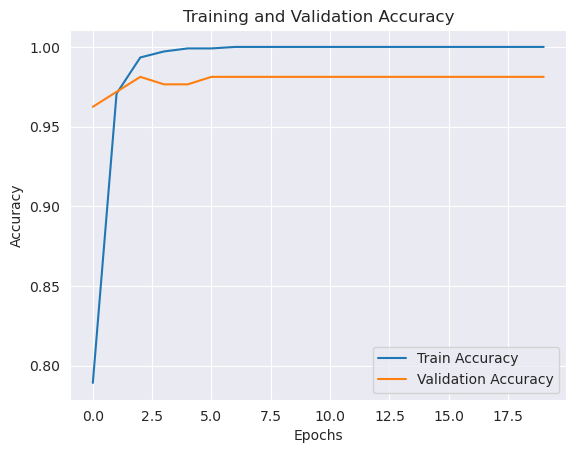

In [33]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Adding a legend to distinguish between train and validation accuracy
plt.legend()

# Display the plot
plt.show()

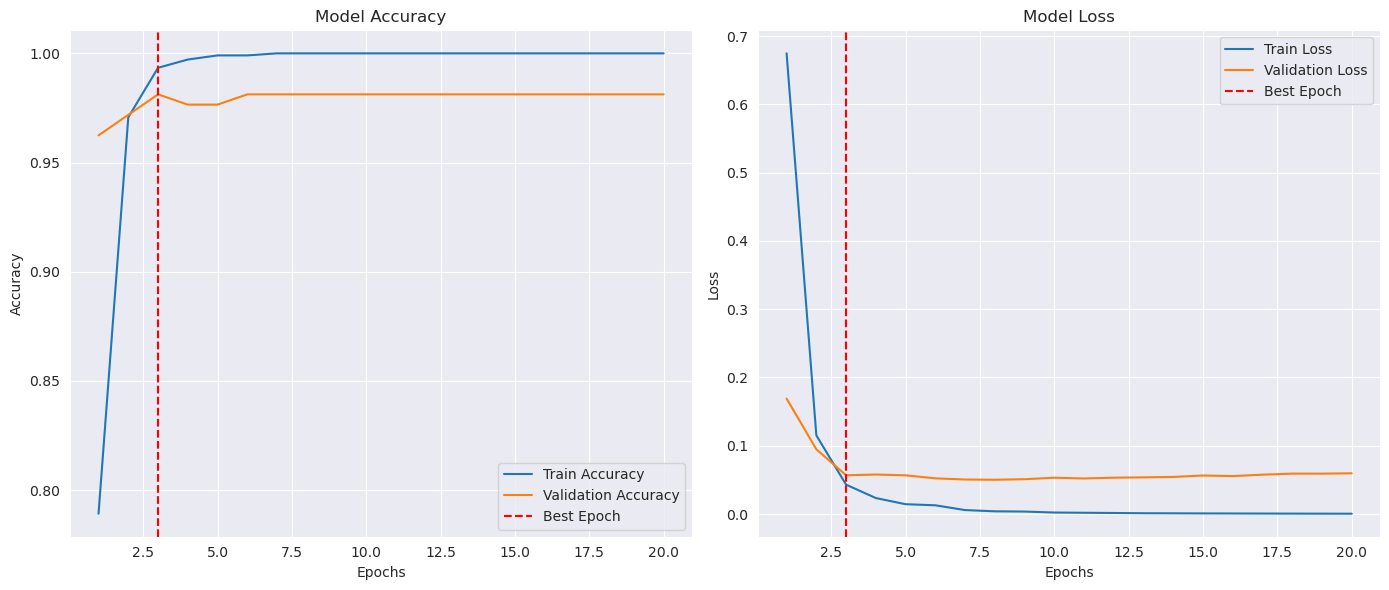

In [34]:
import matplotlib.pyplot as plt

# Find the best epoch based on validation accuracy
best_epoch = max(range(len(history.history['val_accuracy'])), key=lambda i: history.history['val_accuracy'][i])
best_val_acc = history.history['val_accuracy'][best_epoch]
best_val_loss = history.history['val_loss'][best_epoch]

final_train_accuracy = history.history['accuracy'][-1] * 100
final_val_accuracy = history.history['val_accuracy'][-1] * 100

# Plot accuracy and loss
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=best_epoch + 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.axvline(x=best_epoch + 1, color='r', linestyle='--', label='Best Epoch')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


7/7 [==============================] - 26s 3s/step


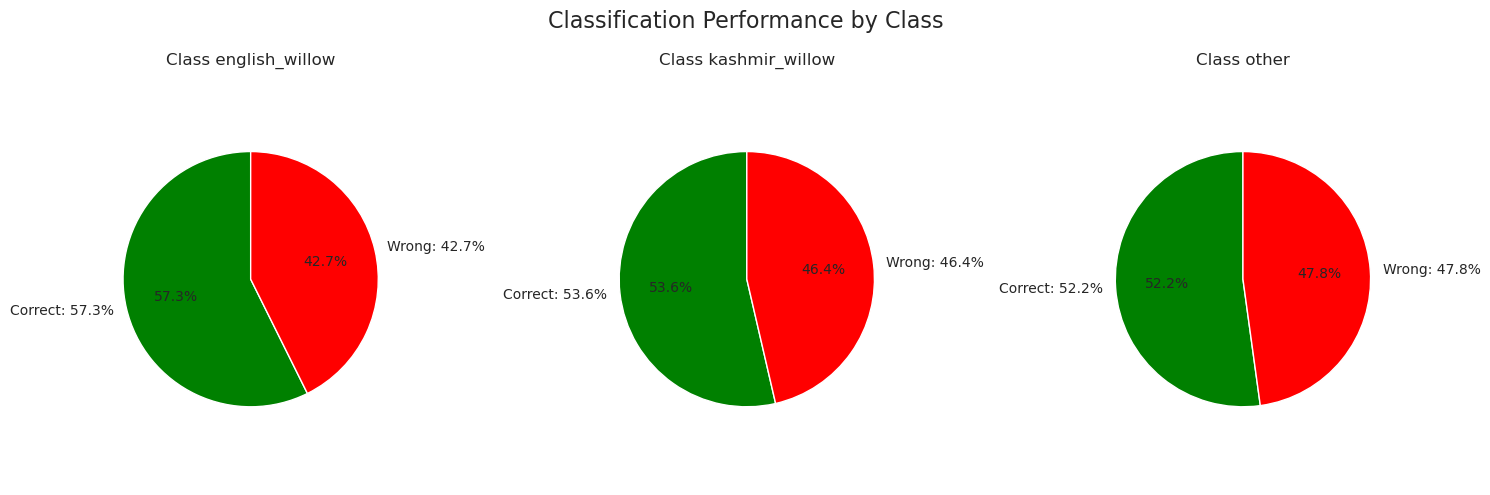

In [35]:
# Get the GLCM features for the test set
test_glcm_features = np.load('glcm_features/test_glcm_features.npy')

predictions = model.predict(
    combined_generator(test_image_generator, test_glcm_features), 
    steps=len(test_image_generator)
)

# Convert the predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels
true_classes = test_image_generator.classes

# Get the class labels
class_labels = list(test_image_generator.class_indices.keys())

# Calculate correct and incorrect predictions per class
class_correct = []
class_wrong = []

for i, label in enumerate(class_labels):
    correct = np.sum((true_classes == i) & (predicted_classes == i))
    wrong = np.sum((true_classes == i) & (predicted_classes != i))
    class_correct.append(correct)
    class_wrong.append(wrong)

# Plot pie charts for each class
fig, axes = plt.subplots(1, len(class_labels), figsize=(15, 5))

for i, label in enumerate(class_labels):
    correct = class_correct[i]
    wrong = class_wrong[i]
    total = correct + wrong
    
    correct_percentage = correct / total * 100
    wrong_percentage = wrong / total * 100
    
    axes[i].pie([correct_percentage, wrong_percentage], labels=[f'Correct: {correct_percentage:.1f}%', f'Wrong: {wrong_percentage:.1f}%'], 
                colors=['green', 'red'], autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'Class {label}')
    axes[i].axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Add a main title to the whole figure
plt.suptitle('Classification Performance by Class', fontsize=16)
plt.tight_layout()
plt.show()


7/7 [==============================] - 23s 3s/step
Confusion Matrix
[[11 64  0]
 [ 0  6 63]
 [64  0  5]]


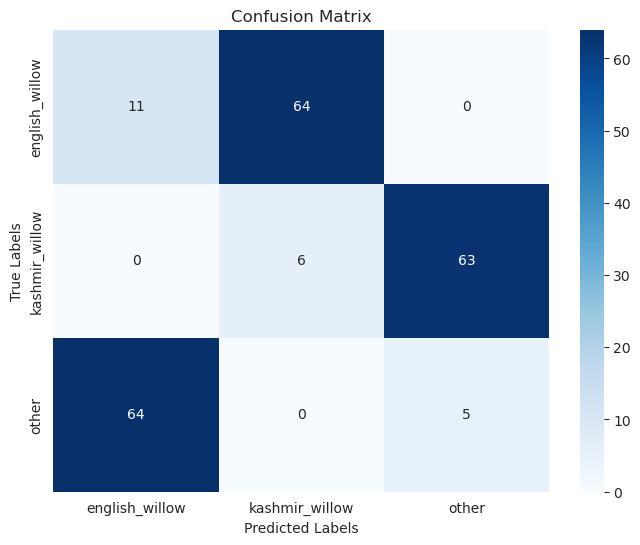

Classification Report
                precision    recall  f1-score   support

english_willow       0.15      0.15      0.15        75
kashmir_willow       0.09      0.09      0.09        69
         other       0.07      0.07      0.07        69

      accuracy                           0.10       213
     macro avg       0.10      0.10      0.10       213
  weighted avg       0.10      0.10      0.10       213



In [36]:
# Get predictions
predictions = model.predict(combined_generator(test_image_generator, test_glcm_features), steps=len(test_image_generator))

# Convert predictions and true labels to categorical format
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_image_generator.classes
class_labels = list(test_image_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report")
print(report)


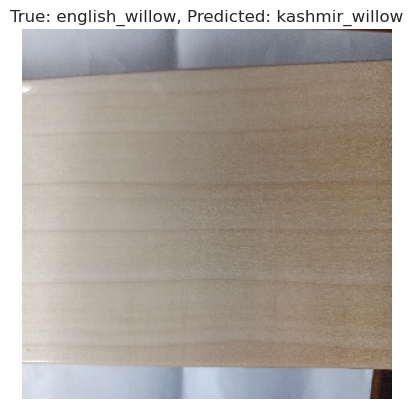

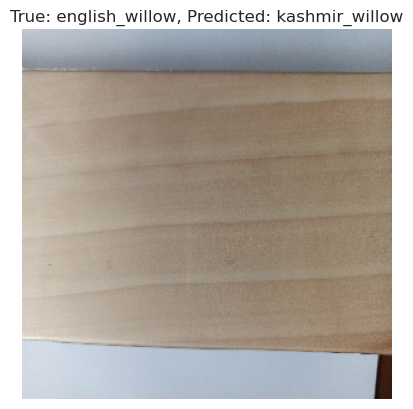

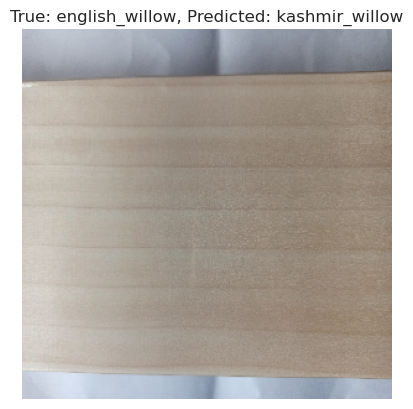

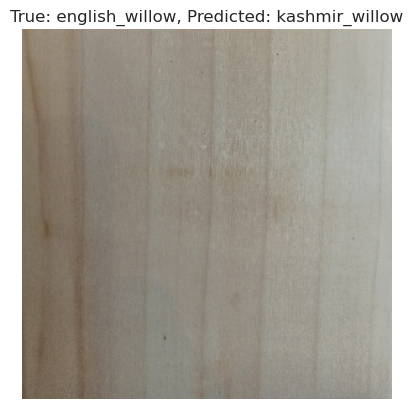

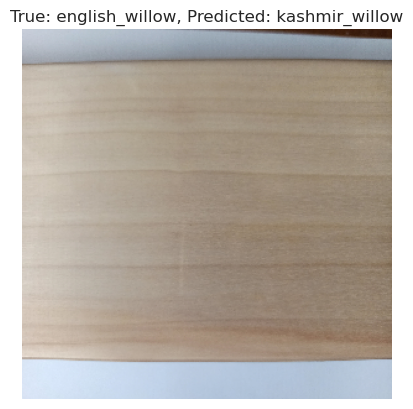

In [37]:
# Extract all the images and labels from the test generator
test_images = []
test_labels = []

for i in range(len(test_image_generator)):
    batch_images, batch_labels = test_image_generator[i]
    test_images.extend(batch_images)
    test_labels.extend(batch_labels)

test_images = np.array(test_images)
test_labels = np.argmax(np.array(test_labels), axis=1)

# Get predicted and true classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels

# Identify misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Display misclassified images
for index in misclassified_indices[:5]:  # Show the first 5 misclassified images
    image = test_images[index]
    true_label = class_labels[true_classes[index]]
    predicted_label = class_labels[predicted_classes[index]]
    
    plt.imshow(image)
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()


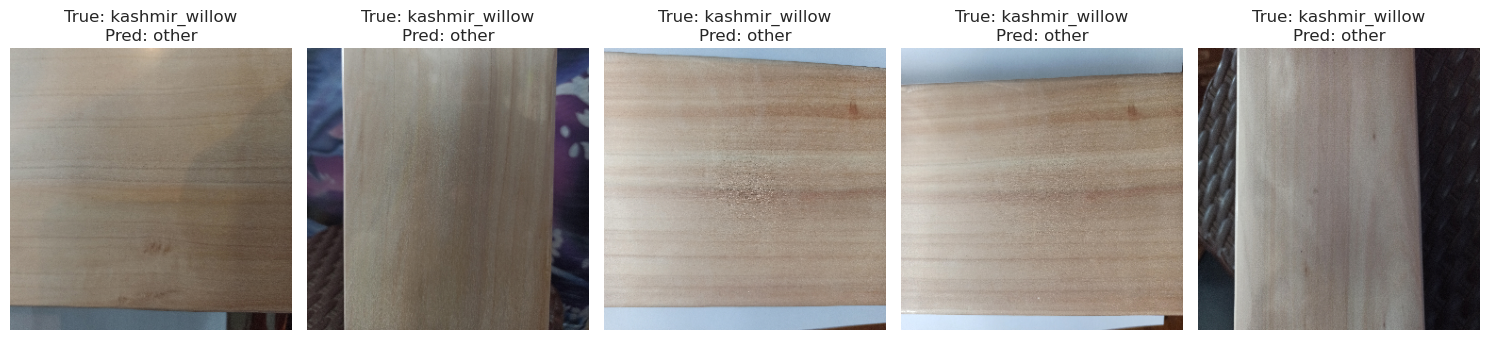

In [38]:
# Extract all the images and labels from the test generator
test_images = []
test_labels = []

for i in range(len(test_image_generator)):
    batch_images, batch_labels = test_image_generator[i]
    test_images.extend(batch_images)
    test_labels.extend(batch_labels)

test_images = np.array(test_images)
test_labels = np.argmax(np.array(test_labels), axis=1)

# Get predicted and true classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels

# Identify misclassified images of Kashmir Willow (assuming 'Kashmir Willow' corresponds to class 1)
misclassified_kashmir_willow_indices = np.where((predicted_classes != true_classes) & (true_classes == 1))[0]

# Display misclassified Kashmir Willow images in a horizontal line
num_images = min(5, len(misclassified_kashmir_willow_indices))  # Limit to 5 images or fewer if less available

# Create a horizontal layout for images
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Loop through the images and display them
for i, index in enumerate(misclassified_kashmir_willow_indices[:num_images]):
    image = test_images[index]
    true_label = class_labels[true_classes[index]]
    predicted_label = class_labels[predicted_classes[index]]

    axes[i].imshow(image)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
    axes[i].axis('off')  # Hide axes for clean display

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [39]:
# Unfreeze some layers in InceptionV3 for fine-tuning
for layer in inception_base.layers[-50:]:  # Adjust this to unfreeze the last 50 layers
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Retrain the model
model.fit(
    combined_generator(train_image_generator, train_glcm_features),
    steps_per_epoch=len(train_image_generator),
    epochs=20,
    validation_data=combined_generator(val_image_generator, val_glcm_features),
    validation_steps=len(val_image_generator)
)


Epoch 1/20
34/34 [==============================] - 188s 5s/step - loss: 1.9707 - accuracy: 0.6229 - val_loss: 0.0739 - val_accuracy: 0.9765
Epoch 2/20
34/34 [==============================] - 170s 5s/step - loss: 0.1964 - accuracy: 0.9263 - val_loss: 0.0675 - val_accuracy: 0.9765
Epoch 3/20
34/34 [==============================] - 167s 5s/step - loss: 0.0518 - accuracy: 0.9868 - val_loss: 0.0550 - val_accuracy: 0.9812
Epoch 4/20
34/34 [==============================] - 160s 5s/step - loss: 0.0613 - accuracy: 0.9764 - val_loss: 0.0549 - val_accuracy: 0.9812
Epoch 5/20
34/34 [==============================] - 205s 6s/step - loss: 0.0256 - accuracy: 0.9953 - val_loss: 0.0488 - val_accuracy: 0.9812
Epoch 6/20
34/34 [==============================] - 227s 7s/step - loss: 0.0229 - accuracy: 0.9915 - val_loss: 0.0382 - val_accuracy: 0.9812
Epoch 7/20
34/34 [==============================] - 240s 7s/step - loss: 0.0260 - accuracy: 0.9934 - val_loss: 0.0310 - val_accuracy: 0.9812
Epoch 8/20
34

In [40]:
# model.save('inceptionv3_bat_classification_model.h5')
model.save('inceptionv3_bat_classification_model.keras')



In [41]:
from tensorflow.keras.models import load_model
model = load_model('inceptionv3_bat_classification_model.keras')


In [42]:
# Load and preprocess the new image
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = '/home/mudeesha/Documents/research/test.jpg'
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Convert the image to grayscale for GLCM
gray_image = rgb2gray(img_array[0])

# Compute GLCM features (use the same parameters as used during training)
glcm_matrix = graycomatrix((gray_image * 255).astype('uint8'), distances=[1], angles=[0], symmetric=True, normed=True)

# Use only 4 GLCM features (like during training)
glcm_contrast = graycoprops(glcm_matrix, 'contrast').flatten()
glcm_homogeneity = graycoprops(glcm_matrix, 'homogeneity').flatten()
glcm_energy = graycoprops(glcm_matrix, 'energy').flatten()
glcm_correlation = graycoprops(glcm_matrix, 'correlation').flatten()

# Combine GLCM features into one feature vector (4 features)
glcm_features = np.concatenate([glcm_contrast, glcm_homogeneity, glcm_energy, glcm_correlation])
glcm_features = np.expand_dims(glcm_features, axis=0)  # Expand dims to match batch size

# Predict class with both image and GLCM features
prediction = model.predict([img_array, glcm_features])
predicted_class = np.argmax(prediction, axis=1)

# Assuming class_labels is a list of your class names, e.g., ['English Willow', 'Kashmir Willow', 'Other']
print(f'Predicted Class: {class_labels[predicted_class[0]]}')


FileNotFoundError: [Errno 2] No such file or directory: '/home/mudeesha/Documents/research/test.jpg'